In [1]:
from engine import val_step
from utils.utils import souping, greedy_souping
from models import get_model

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision

from dataset import RSNADataset, HAM10000Dataset, AptosDataset
from torchvision.transforms.v2 import AutoAugmentPolicy, functional as F, InterpolationMode, Transform
from torchvision.transforms import v2
torchvision.disable_beta_transforms_warning()
from timm.data.transforms import RandomResizedCropAndInterpolation
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import argparse

from utils.utils import EarlyStopper, get_dataset
from torch.utils.data.dataset import Subset

import yaml
import json
import time
import os
import wandb
from utils.utils import load_model
import sys


In [2]:

def get_xy(point, origin, vector_x, vector_y):
    return np.array([np.dot(point - origin, vector_x), np.dot(point - origin, vector_y)])


def angle_distance_between_vectors(vectors):
    """
    Calculate the angle between the second and third vectors with respect to the origin.

    Parameters:
    - vectors: numpy array, each row represents a vector

    Returns:
    - angle_deg: float, angle in degrees
    """
    # Extract the second and third vectors from the array
    # vector1 = vectors[1]
    # vector2 = vectors[2]

    # # Calculate vectors from origin to the given points
    vector1 = vectors[1]
    vector2 = vectors[2]

    # Calculate vectors from origin to the given points
    origin = np.zeros_like(vector1)
    vector1_from_origin = vector1 - origin
    vector2_from_origin = vector2 - origin

    # Calculate the dot product
    dot_product = np.dot(vector1_from_origin, vector2_from_origin)

    # Calculate the magnitudes
    magnitude_vector1 = np.linalg.norm(vector1_from_origin)
    magnitude_vector2 = np.linalg.norm(vector2_from_origin)

    # Calculate the cosine of the angle
    cosine_theta = dot_product / (magnitude_vector1 * magnitude_vector2)
    theta_rad = np.arccos(np.clip(cosine_theta, -1.0, 1.0))
    l2_distance = np.linalg.norm(vector1_from_origin - vector2_from_origin)
    # print(theta_rad, l2_distance)
    # Convert angle to degrees
    angle_deg = np.degrees(theta_rad)

    return angle_deg, l2_distance


In [3]:
WEIGHT_PATH_v2 = '/l/users/santosh.sanjeev/model_soups/runs/san_final_hyp_models/san-finetune/cifar100_final_hyp/deit-s/2024-01-18_19-46-03/'
initial_val_df = pd.read_csv('/home/santosh.sanjeev/Projects/model-soups/noodles/test/Cifar100/DeiT-S/VAL_RESULTS.csv')
initial_test_df = pd.read_csv('/home/santosh.sanjeev/Projects/model-soups/noodles/test/Cifar100/DeiT-S/TEST_RESULTS.csv')
DATASET = 'Cifar10'
PRETRAINING = 'ImageNet'
IMAGE_SIZE = 224
BATCH_SIZE = 128
NUM_WORKERS = 16
TASK = 'Classification'
CLASSIFICATION = 'MultiClass'
loss = torch.nn.CrossEntropyLoss()
PATHS = './dataset/cifar""./dataset/cifar/cifar1098_idxs.npy'#'./dataset/rsna18""./dataset/rsna18/csv/final_dataset_wo_not_normal_cases.csv'
NUM_CLASSES = 100
MODEL = 'DeiT-S'
DEVICE = 'cuda'
val_sort_by = 'Val Accuracy'
initial_model_path = '/home/santosh.sanjeev/Projects/model-soups/noodles/runs/san_final_hyp_models/san-initial_models/cifar100/deits_cifar100/best_checkpoint.pth'
train_loader, val_loader, test_loader = get_dataset(DATASET, PATHS, "Minimal", 
                                                        PRETRAINING, IMAGE_SIZE, BATCH_SIZE, NUM_WORKERS, TASK)

state_dicts = []
for idx, folder in enumerate(sorted(os.listdir(WEIGHT_PATH_v2))):
    print(idx)
    if folder.startswith('testresults'):
        continue
    model_path = os.path.join(WEIGHT_PATH_v2, folder)
    train_summary = json.load(open(os.path.join(model_path, "train_summary.json"), 'r'))
    model_config = train_summary["config"]

    checkpoint = torch.load(os.path.join(model_path, "best_checkpoint.pth"), map_location=DEVICE)
    state_dicts.append(checkpoint['model'])


['./dataset/cifar', './dataset/cifar/cifar1098_idxs.npy']
Cifar10 45000 5000 10000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


In [4]:

alphal = [1 / len(state_dicts) for i in range(len(state_dicts))]
model = get_model(MODEL, num_classes=NUM_CLASSES)
uniform_model = souping(model, state_dicts, alphal)
uniform_model.to(DEVICE)
uniform_test_loss, uniform_test_acc, uniform_test_f1, uniform_test_recall, uniform_test_kappa, uniform_test_auc = val_step(uniform_model, test_loader, train_loader, loss, DEVICE, CLASSIFICATION)
print(uniform_test_acc)

  0%|          | 0/79 [00:00<?, ?it/s]

In [10]:
md = uniform_model
print(md.keys())

AttributeError: 'VisionTransformer' object has no attribute 'keys'

In [17]:
angle_list = []
distance_list = []
import copy
for index, row in initial_val_df.iterrows():
    model_id = initial_val_df.iloc[index]['Model Name']
    # model = get_model(MODEL, num_classes=NUM_CLASSES)
    # model = model.to(DEVICE)
    model1 = get_model(MODEL, num_classes=NUM_CLASSES)
    model1.load_state_dict(torch.load(initial_model_path,map_location='cuda')['model'])
    model1 = model1.to(DEVICE)
    alphal = [1 / len(state_dicts) for i in range(len(state_dicts))]
    model = get_model(MODEL, num_classes=NUM_CLASSES)
    model2 = souping(model, state_dicts, alphal)
    model2.to(DEVICE)
    
    model3 = get_model(MODEL, num_classes=NUM_CLASSES)
    model3.load_state_dict(state_dicts[index])
    model3 = model3.to(DEVICE)

    w = list()
    curve_parameters = [model1.parameters(), model2.parameters(), model3.parameters()]
    for i in range(3):
        w.append(np.concatenate([
            p.data.cpu().numpy().ravel() for p in curve_parameters[i]
        ]))

    u = w[1] - w[0]
    dx = np.linalg.norm(u)
    u /= dx
    v = w[2] - w[0]
    v -= np.dot(u, v) * u
    dy = np.linalg.norm(v)
    v /= dy
    bend_coordinates = np.stack(get_xy(p, w[0], u, v) for p in w)
    angle, distance = angle_distance_between_vectors(bend_coordinates)
    print(angle, distance)
    angle_list.append(angle)
    distance_list.append(distance)
    # model_data.append((model_id, angle, initial_val_df.iloc[index]['Learning Rate']))
#     print(model_id, angle, initial_val_df.iloc[index]['Learning Rate'])
# # Sort the model IDs based on angles in descending order
# sorted_model_data = sorted(model_data, key=lambda x: x[1], reverse=True)

# # Extract sorted model IDs and angles
# sorted_model_ids = [model_id for model_id, angle, LRv in sorted_model_data]
# sorted_angles = [angle for model_id, angle, LRv in sorted_model_data]
# sorted_LRs = [LRv for model_id, angle, LRv in sorted_model_data]
# print("Sorted Model IDs based on angle:")
# print(sorted_model_ids)
# print("Corresponding Angles:")
# print(sorted_angles)
# print("Corresponding LR:")
# print(sorted_LRs)


68.95294440884253 315.0533
69.78281053207563 351.96506
65.06223905616531 395.075
67.03310619671231 387.0128
59.97589494031693 428.6333
62.23343966198266 420.6024
68.26791312577441 179.90086
65.9391001673391 219.38786
64.76830356087912 230.17303
64.80834147097035 233.22238
65.35036495414269 231.38951
65.3152612486051 233.24673
81.75393636115481 35.30099
76.2594813767861 55.987625
77.47247321980417 43.241028
78.72243245674031 39.015305
75.90934827404132 60.2335
75.98368463487714 60.310795
80.66171855345854 36.56613
82.70423103168993 34.5141
78.87902709978383 36.54693
79.44520289141792 35.838135
78.4040666220936 41.67826
78.38816450834518 41.703117
83.17052465773445 34.45023
83.15541254710918 34.452156
80.12749823718269 34.36198
80.19341701575786 34.332047
80.73953651491716 34.370052
80.8394198223126 34.374428
83.38813066993089 34.48956
83.37812094598512 34.496727
80.51123618387054 34.220516
80.52475339353724 34.22222
81.01631309880263 34.26995
81.06750395271902 34.274525
83.7964407684262

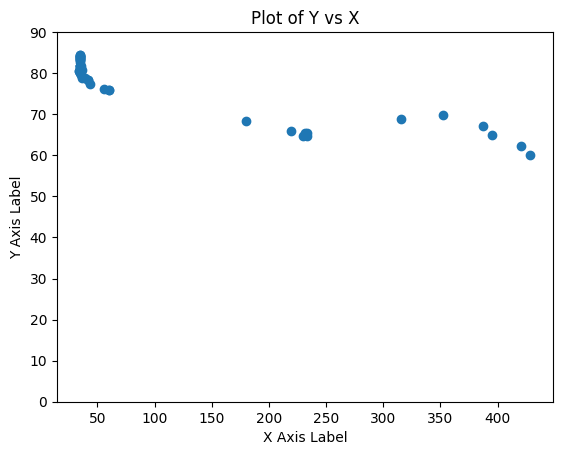

In [18]:
#CIFAR10
import matplotlib.pyplot as plt

# Assuming you have two lists representing x and y values
# Plot the data
plt.scatter(distance_list, angle_list)

# Set labels and title
plt.xlabel('X Axis Label')
plt.ylabel('Y Axis Label')
plt.title('Plot of Y vs X')

# Set y-axis limits
plt.ylim(0, 90)

# Show the plot
plt.show()


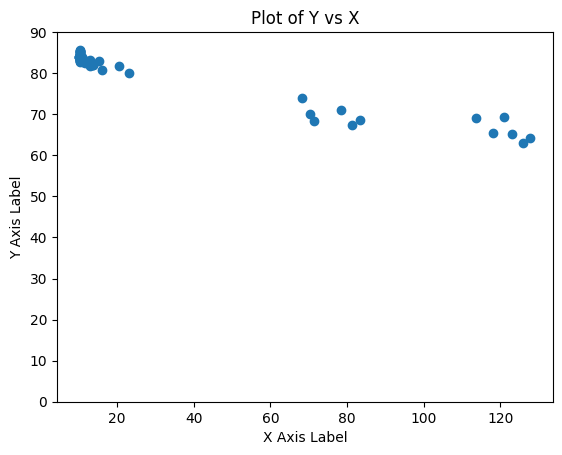

In [11]:
#RSNA
import matplotlib.pyplot as plt

# Assuming you have two lists representing x and y values
# Plot the data
plt.scatter(distance_list, angle_list)

# Set labels and title
plt.xlabel('X Axis Label')
plt.ylabel('Y Axis Label')
plt.title('Plot of Y vs X')

# Set y-axis limits
plt.ylim(0, 90)

# Show the plot
plt.show()


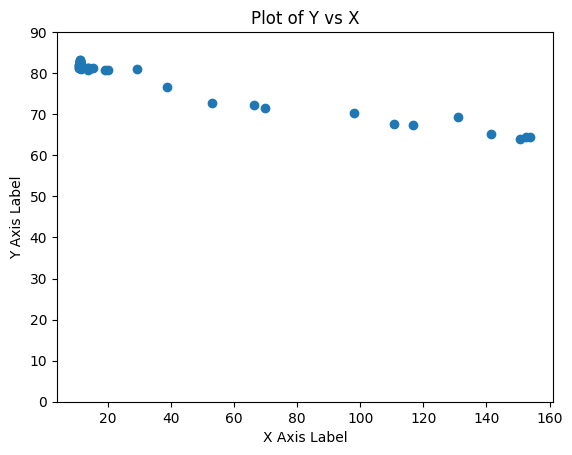

In [6]:
import matplotlib.pyplot as plt

# Assuming you have two lists representing x and y values
# Plot the data
plt.scatter(distance_list, angle_list)

# Set labels and title
plt.xlabel('X Axis Label')
plt.ylabel('Y Axis Label')
plt.title('Plot of Y vs X')

# Set y-axis limits
plt.ylim(0, 90)

# Show the plot
plt.show()


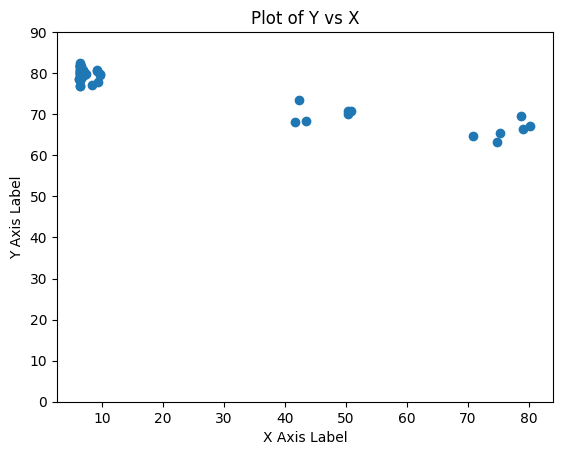

In [14]:
import matplotlib.pyplot as plt

# Assuming you have two lists representing x and y values
# Plot the data
plt.scatter(distance_list, angle_list)

# Set labels and title
plt.xlabel('X Axis Label')
plt.ylabel('Y Axis Label')
plt.title('Plot of Y vs X')

# Set y-axis limits
plt.ylim(0, 90)

# Show the plot
plt.show()


In [7]:

def get_xy(point, origin, vector_x, vector_y):
    return np.array([np.dot(point - origin, vector_x), np.dot(point - origin, vector_y)])


def angle_distance_between_vectors_v2(vector1, vector2):
    """
    Calculate the angle between the second and third vectors with respect to the origin.

    Parameters:
    - vectors: numpy array, each row represents a vector

    Returns:
    - angle_deg: float, angle in degrees
    """
    # Extract the second and third vectors from the array
    # vector1 = vectors[1]
    # vector2 = vectors[2]

    # # Calculate vectors from origin to the given points
    # vector1 = vectors[1]
    # vector2 = vectors[2]

    # # Calculate vectors from origin to the given points
    # origin = np.zeros_like(vector1)
    # vector1_from_origin = vector1 - origin
    # vector2_from_origin = vector2 - origin

    # Calculate the dot product
    dot_product = np.dot(vector1, vector2)

    # Calculate the magnitudes
    # magnitude_vector1 = np.linalg.norm(vector1_from_origin)
    # magnitude_vector2 = np.linalg.norm(vector2_from_origin)

    # Calculate the cosine of the angle
    cosine_theta = dot_product #/ (magnitude_vector1 * magnitude_vector2)
    theta_rad = np.arccos(np.clip(cosine_theta, -1.0, 1.0))
    l2_distance = np.linalg.norm(vector1 - vector2)
    # print(theta_rad, l2_distance)
    # Convert angle to degrees
    angle_deg = np.degrees(theta_rad)

    return angle_deg, l2_distance


In [8]:
angle_list = []
distance_list = []
for index, row in initial_val_df.iterrows():
    model_id = initial_val_df.iloc[index]['Model Name']
    # model = get_model(MODEL, num_classes=NUM_CLASSES)
    # model = model.to(DEVICE)
    model1 = get_model(MODEL, num_classes=NUM_CLASSES)
    model1.load_state_dict(torch.load(initial_model_path,map_location='cuda')['model'])
    model1 = model1.to(DEVICE)
    
    model2 = uniform_model #get_model(MODEL, num_classes=NUM_CLASSES)

    model3 = get_model(MODEL, num_classes=NUM_CLASSES)
    model3 = model3.to(DEVICE)

    w = list()
    curve_parameters = [model1.parameters(), model2.parameters(), model3.parameters()]
    for i in range(3):
        w.append(np.concatenate([
            p.data.cpu().numpy().ravel() for p in curve_parameters[i]
        ]))

    u = w[1] - w[0]
    dx = np.linalg.norm(u)
    u /= dx
    v = w[2] - w[0]
    # v -= np.dot(u, v) * u
    dy = np.linalg.norm(v)
    v /= dy
    bend_coordinates = np.stack(get_xy(p, w[0], u, v) for p in w)
    angle, distance = angle_distance_between_vectors(bend_coordinates)
    print(angle, distance)
    angle_list.append(angle)
    distance_list.append(distance)
    # model_data.append((model_id, angle, initial_val_df.iloc[index]['Learning Rate']))
#     print(model_id, angle, initial_val_df.iloc[index]['Learning Rate'])
# # Sort the model IDs based on angles in descending order
# sorted_model_data = sorted(model_data, key=lambda x: x[1], reverse=True)

# # Extract sorted model IDs and angles
# sorted_model_ids = [model_id for model_id, angle, LRv in sorted_model_data]
# sorted_angles = [angle for model_id, angle, LRv in sorted_model_data]
# sorted_LRs = [LRv for model_id, angle, LRv in sorted_model_data]
# print("Sorted Model IDs based on angle:")
# print(sorted_model_ids)
# print("Corresponding Angles:")
# print(sorted_angles)
# print("Corresponding LR:")
# print(sorted_LRs)


82.73761798467454 599.54407
82.73611781988535 599.5108
82.73986176741836 599.5533
82.74398437703859 599.52374
82.73426563017524 599.531
82.73879194835048 599.5373
82.73277922519803 599.5469
82.74366420912668 599.51184
82.73117576139116 599.58075
82.73355040060018 599.54767
82.73743638151542 599.5405
82.73762917349237 599.53595
82.73605499015501 599.53436
82.74284227164304 599.5594
82.73806725852546 599.52893
82.73693718761953 599.5541
82.7350230320944 599.547
82.7400364842086 599.5355
82.73845628456249 599.5461
82.73528037631958 599.52625
82.73727887729433 599.5309
82.7357726866007 599.5671
82.73788995893678 599.5561
82.73974987978303 599.5501
82.73852341734013 599.5523
82.74191447025011 599.5762
82.73450317909638 599.5422
82.73930663233877 599.5515
82.7428396896381 599.5486
82.74398695903695 599.52704
82.73786758131382 599.538
82.74129909071979 599.4947
82.73456945178023 599.5235
82.73157770374178 599.57184
82.73637258144169 599.56537
82.73509274743417 599.54315
82.74105293867194 599.